- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns


sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans']
    }
)
sns.set_palette('colorblind')

---

In [2]:
# write down .pkl with baseline variant_test_data for analyses where others are N/A
#
#cp100 = pd.read_pickle('___4x_cal-test_combos__100x_cp__per_variant_test_data__cp_instance_col.pkl')
#cp100['ps_size'] = cp100['classes'].apply(len)
#cp100[(cp100['variant_test_data']=='baseline')].to_pickle('___4x_cal-test_combos__100x_cp__only_baseline_variant_test_data__cp_instance_col.pkl')

cp100 = pd.read_pickle('___4x_cal-test_combos__100x_cp__only_baseline_variant_test_data__cp_instance_col.pkl')
print(cp100.columns)
print(cp100.cal_test.unique())

Index(['dataset', 'scan_id', 'slice_idx', 'class', 'predicted_class',
       'is_correct', 'pred_prob_0', 'pred_prob_1', 'actual_class_pred_prob',
       'variant_test_data', 'model', 'confidence', 'credibility', 'margin',
       'classes', 'verdict', 'class_conditional', 'cp', 'run', 'cal_test',
       'ps_size'],
      dtype='object')
['dv3T-cal_dv3T-test' 'baseline3T-cal_dv3T-test'
 'baseline3T-cal_dv1.5T-test' 'dv1.5T-cal_dv1.5T-test']


---

# Conformal Predictor Efficiency

- 3T vs 1.5T
- Not Class-Conditional (NCC) vs Class-Conditional (CC)
- Overall vs Class 0 vs Class 1

(baseline data)

In [3]:
# Define all 4 combinations
combinations = [
    {'cal_test': 'dv3T-cal_dv3T-test', 'class_conditional': False},
    {'cal_test': 'dv3T-cal_dv3T-test', 'class_conditional': True},
    {'cal_test': 'dv1.5T-cal_dv1.5T-test', 'class_conditional': False},
    {'cal_test': 'dv1.5T-cal_dv1.5T-test', 'class_conditional': True}
]

# categorize outcomes
def categorize(size, verdict):
    if size == 0:
        return "Empty"
    elif size == 1 and verdict:
        return "Correct single-label"
    elif size == 1 and not verdict:
        return "Incorrect single-label"
    elif size > 1:
        return "Multiple-label"
    else:
        raise ValueError("Unexpected case")

# process data for a given combination and class subset
def process_combination(df_subset, title_suffix=""):
    alpha_to_ps_size_and_verdict_tuples = {}
    alphas = np.linspace(0.01, 0.99, 99).round(2)
    
    for alpha in alphas:
        alpha_to_ps_size_and_verdict_tuples[alpha] = df_subset.apply(lambda x: (
            len(x['cp'].classes(alpha)), 
            x['cp'].verdict(x['class'], alpha)
        ), axis=1).values
    
    # initialize results
    records = []
    for alpha, tuples in alpha_to_ps_size_and_verdict_tuples.items():
        categories = [categorize(size, verdict) for size, verdict in tuples]
        counts = pd.Series(categories).value_counts(normalize=True)
        counts["Significance"] = alpha
        records.append(counts)
    
    df_plot = pd.DataFrame(records).fillna(0).sort_values("Significance")
    
    # add single-label column (correct + incorrect single-label predictions)
    df_plot['Single-label'] = (df_plot['Correct single-label'] + 
                              df_plot['Incorrect single-label'])

    # add coverage column (correct single-label + multiple-label predictions)
    df_plot['Coverage'] = (df_plot['Correct single-label'] + 
                          df_plot['Multiple-label'])
    
    # define column order
    display_columns = [
        "Empty", 
        "Single-label",
        "Incorrect single-label", 
        "Correct single-label", 
        "Multiple-label", 
        "Coverage",
        "Significance"
    ]
    
    # reorder columns
    df_plot = df_plot[display_columns]
    
    # find most efficient based on maximum single-label fraction (efficiency metric)
    most_efficient = df_plot[df_plot['Single-label'] == df_plot['Single-label'].max()]
    
    return df_plot, most_efficient

# process each combination
results = {}
for i, combo in enumerate(combinations):
    combo_name = f"{combo['cal_test']}_{'CC' if combo['class_conditional'] else 'NCC'}"
    
    # filter data for this combination
    df_combo = cp100[(cp100['cal_test'] == combo['cal_test']) & 
                     (cp100['class_conditional'] == combo['class_conditional'])]
    
    # overall results
    df_plot_overall, most_efficient_overall = process_combination(df_combo, "Overall")
    
    # class-specific results
    df_plot_class0, most_efficient_class0 = process_combination(
        df_combo[df_combo['class'] == 0], "Class 0")
    df_plot_class1, most_efficient_class1 = process_combination(
        df_combo[df_combo['class'] == 1], "Class 1")
    
    results[combo_name] = {
        'overall': (df_plot_overall, most_efficient_overall),
        'class0': (df_plot_class0, most_efficient_class0),
        'class1': (df_plot_class1, most_efficient_class1)
    }

# save for future sessions
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

Load saved results

In [31]:
# load
with open("results.pkl", "rb") as f:
    results = pickle.load(f)

## Visualize Efficiency of Conformal Predictors & Prediction Set Distribution

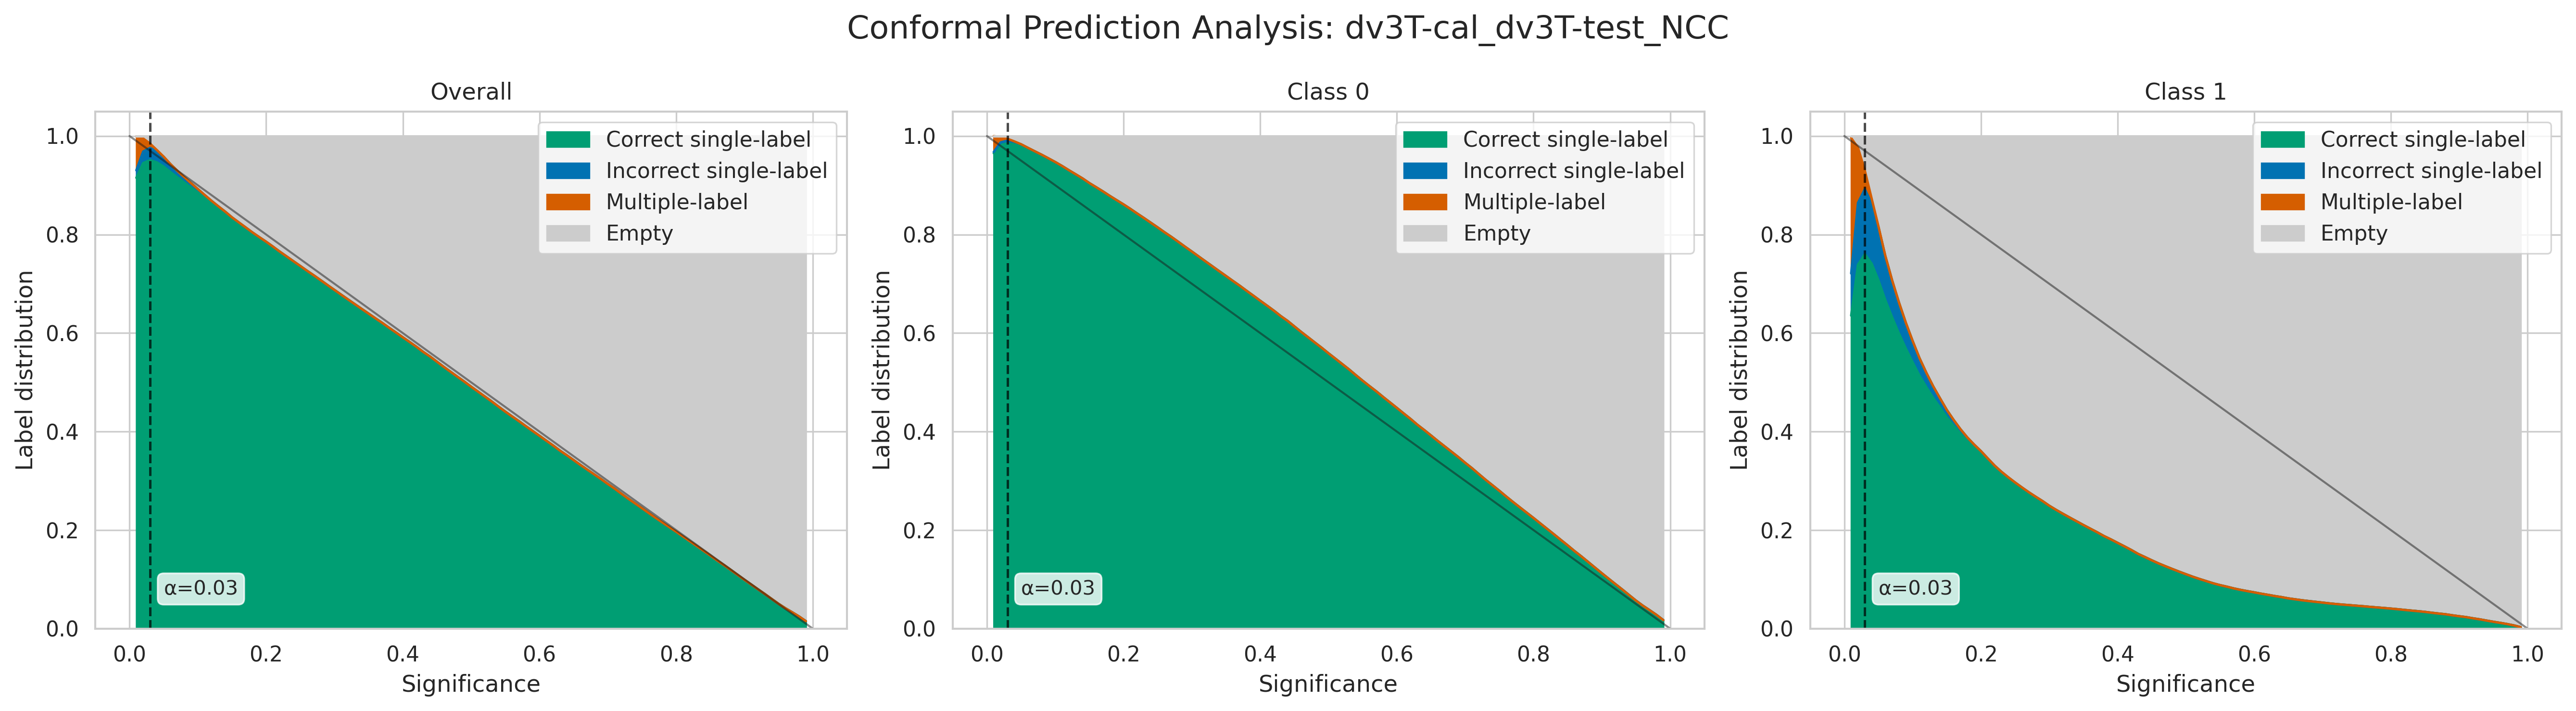


dv3T-cal_dv3T-test_NCC - Most Efficient Alpha Values:
Overall: α = 0.03
Class 0: α = 0.03
Class 1: α = 0.03

dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Overall):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.015344,0.9757,0.024805,0.950895,0.008956,0.959851,0.03



dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Class 0):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.005594,0.990598,0.005723,0.984875,0.003808,0.988683,0.03



dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Class 1):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.070121,0.892001,0.132009,0.759993,0.037877,0.79787,0.03


--------------------------------------------------------------------------------


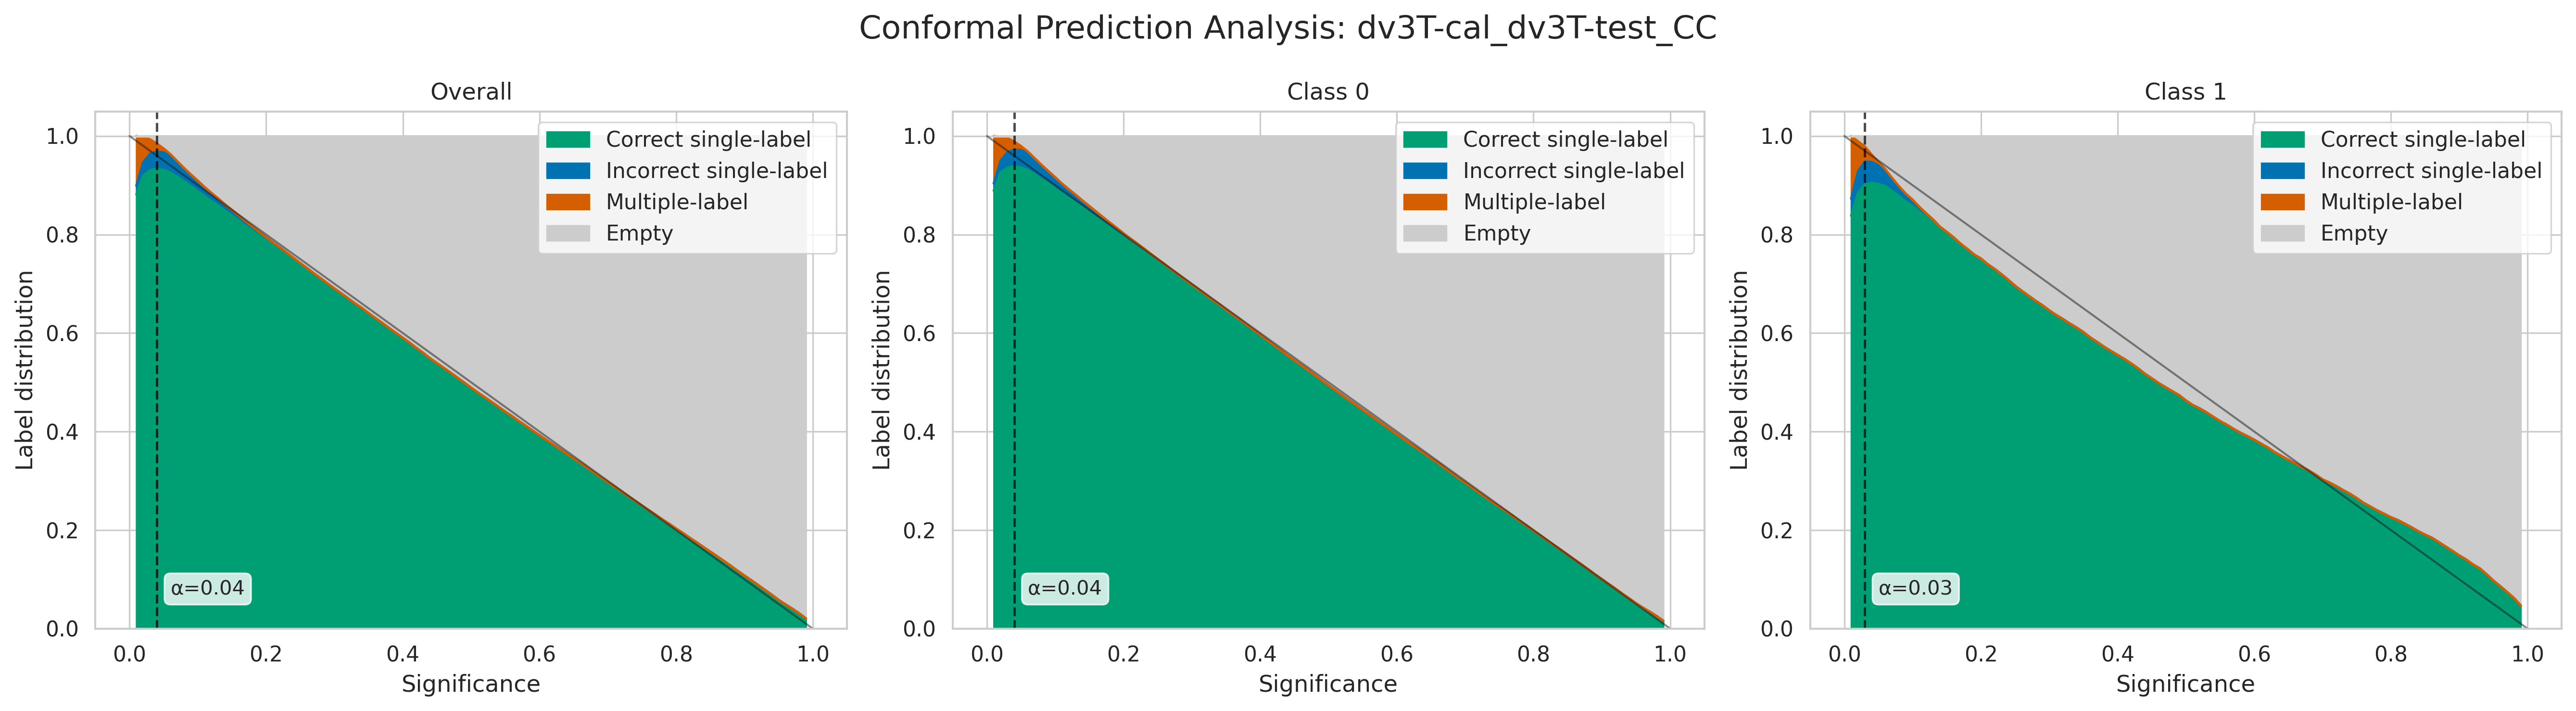


dv3T-cal_dv3T-test_CC - Most Efficient Alpha Values:
Overall: α = 0.04
Class 0: α = 0.04
Class 1: α = 0.03

dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Overall):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.015379,0.968458,0.035265,0.933193,0.016163,0.949356,0.04



dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Class 0):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.011405,0.972262,0.034006,0.938257,0.016333,0.95459,0.04



dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Class 1):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.02124,0.948132,0.046312,0.901821,0.030628,0.932449,0.03


--------------------------------------------------------------------------------


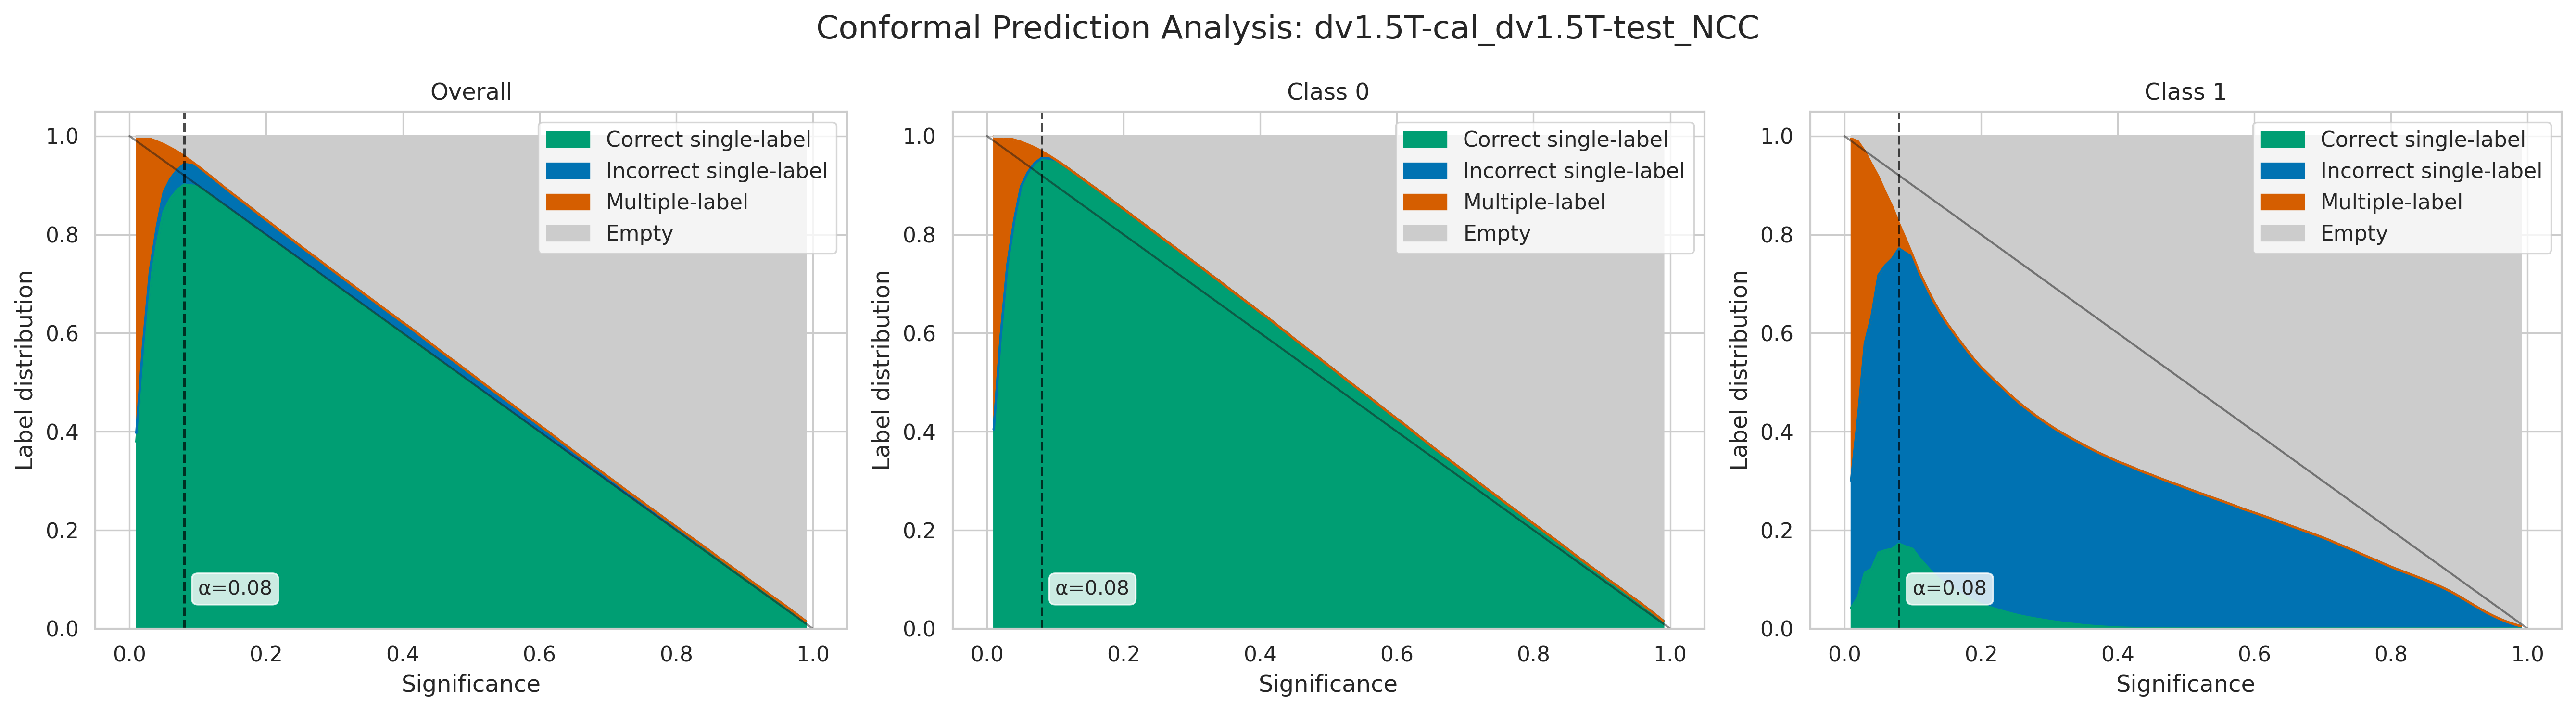


dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Alpha Values:
Overall: α = 0.08
Class 0: α = 0.08
Class 1: α = 0.08

dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Overall):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.040966,0.942818,0.041617,0.901201,0.016216,0.917417,0.08



dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Class 0):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.030879,0.955461,0.00045,0.95501,0.013661,0.968671,0.08



dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Class 1):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.177633,0.771529,0.599354,0.172175,0.050839,0.223014,0.08


--------------------------------------------------------------------------------


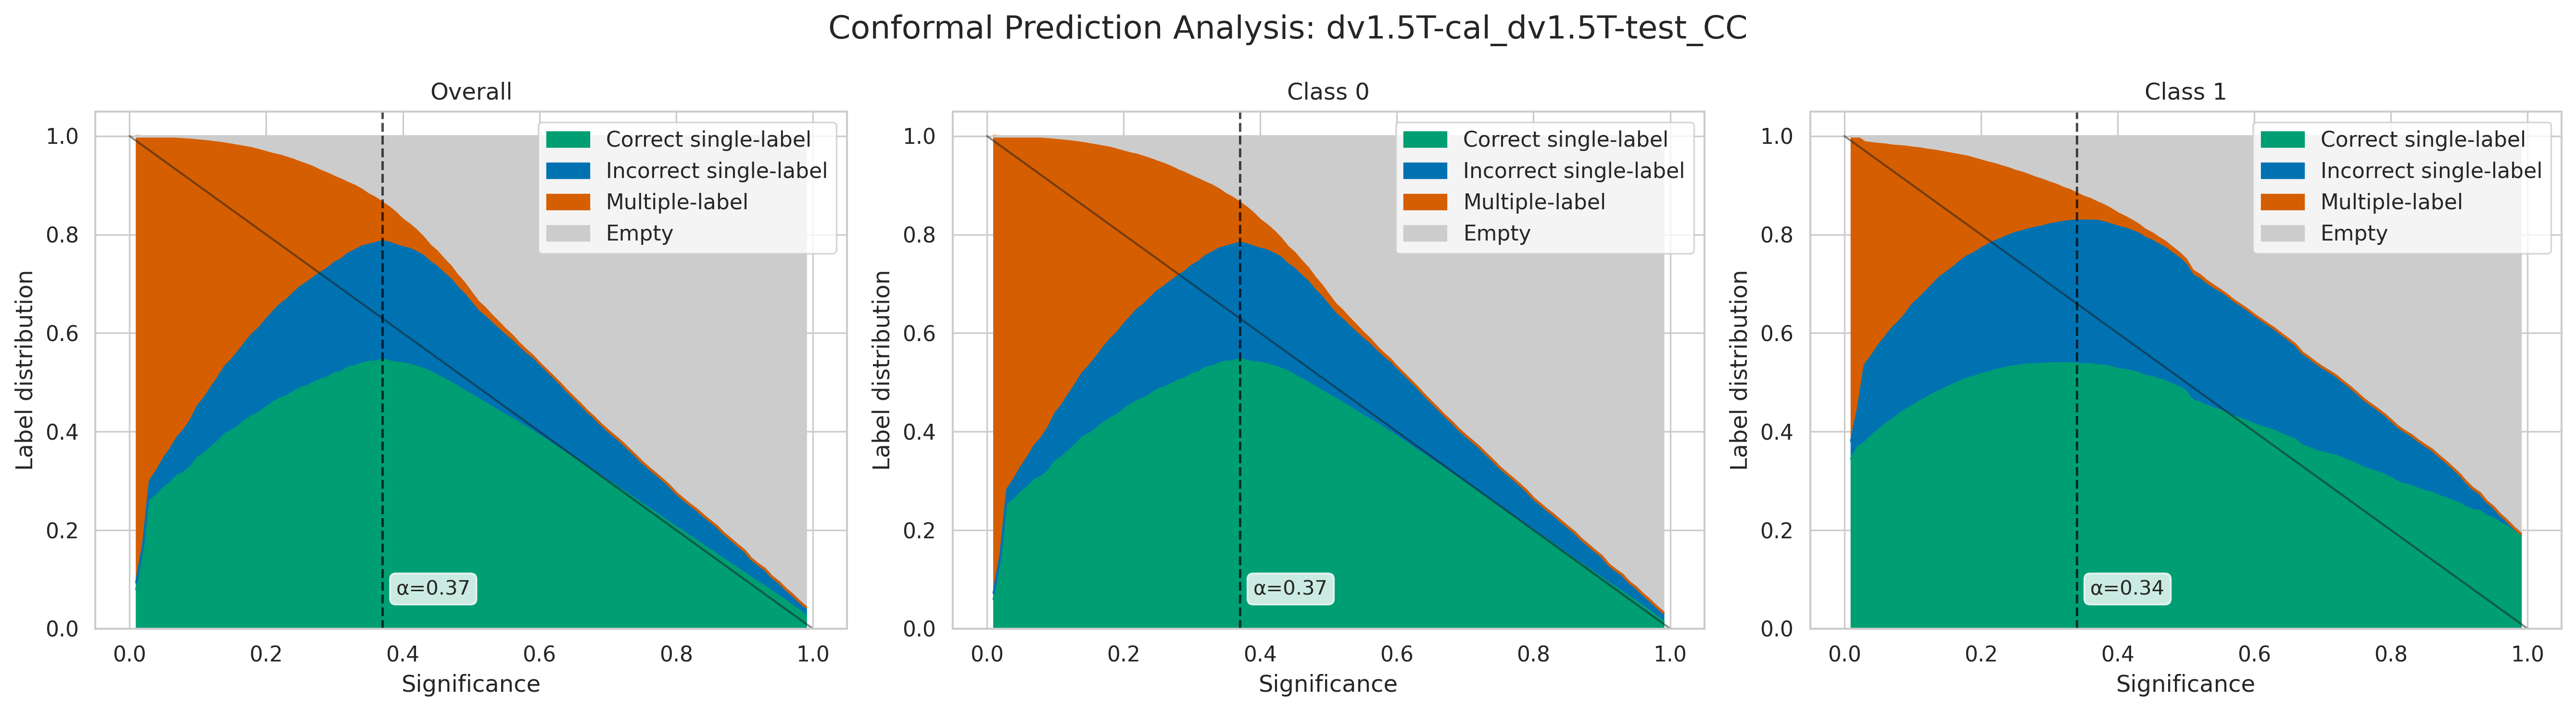


dv1.5T-cal_dv1.5T-test_CC - Most Efficient Alpha Values:
Overall: α = 0.37
Class 0: α = 0.37
Class 1: α = 0.34

dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Overall):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.135529,0.786228,0.240442,0.545786,0.078244,0.624029,0.37



dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Class 0):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.135585,0.78318,0.236539,0.54664,0.081236,0.627876,0.37



dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Class 1):


,Empty,Single-label,Incorrect single-label,Correct single-label,Multiple-label,Coverage,Significance
proportion,0.116795,0.828119,0.290671,0.537448,0.055086,0.592534,0.34


--------------------------------------------------------------------------------


In [47]:
# Function to create plot
def create_plot(df_plot, most_efficient, ax, title):
    categories_order = ["Correct single-label", "Incorrect single-label", "Multiple-label", "Empty"]

    # color-blind friendly
    colors = {
        "Correct single-label": "#009E73",      # Teal green (from colorbrewer)
        "Incorrect single-label": "#0072B2",    # Blue 
        "Multiple-label": "#D55E00",            # Vermillion (orange-red)
        "Empty": "#CCCCCC"                      # Light gray
    }
    
    df_plot.set_index("Significance")[categories_order].plot.area(
        stacked=True, color=[colors[c] for c in categories_order], ax=ax
    )

    ax.plot([0, 1], [1, 0], 'k-', alpha=0.5, linewidth=1)
    
    # Add dashed vertical line at most efficient significance
    most_efficient_alpha = most_efficient['Significance'].iloc[0]
    ax.axvline(x=most_efficient_alpha, color='black', linestyle='--', alpha=0.7)

    # Add text label adjacent to the vertical line
    ax.text(most_efficient_alpha + 0.02, 0.1, f'α={most_efficient_alpha:.2f}', 
            rotation=0, verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlabel("Significance")
    ax.set_ylabel("Label distribution")
    ax.set_title(title)
    ax.legend(loc="upper right")
    
    return most_efficient_alpha

# Create plots for each combination
for combo_name, combo_results in results.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Conformal Prediction Analysis: {combo_name}', fontsize=16)
    
    # Overall plot
    df_plot_overall, most_efficient_overall = combo_results['overall']
    alpha_overall = create_plot(df_plot_overall, most_efficient_overall, axes[0], 'Overall')
    
    # Class 0 plot
    df_plot_class0, most_efficient_class0 = combo_results['class0']
    alpha_class0 = create_plot(df_plot_class0, most_efficient_class0, axes[1], 'Class 0')
    
    # Class 1 plot
    df_plot_class1, most_efficient_class1 = combo_results['class1']
    alpha_class1 = create_plot(df_plot_class1, most_efficient_class1, axes[2], 'Class 1')
    
    plt.tight_layout()

    # Save the plot as high DPI PNG
    filename = f"9-2-3__conformal_efficiency__{combo_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    # Display most efficient values
    print(f"\n{combo_name} - Most Efficient Alpha Values:")
    print(f"Overall: α = {alpha_overall:.2f}")
    print(f"Class 0: α = {alpha_class0:.2f}")
    print(f"Class 1: α = {alpha_class1:.2f}")
    
    print(f"\n{combo_name} - Most Efficient Statistics (Overall):")
    display(most_efficient_overall)
    
    print(f"\n{combo_name} - Most Efficient Statistics (Class 0):")
    display(most_efficient_class0)
    
    print(f"\n{combo_name} - Most Efficient Statistics (Class 1):")
    display(most_efficient_class1)
    print("-" * 80)

---
---

Preserve text output as markdown

```
dv3T-cal_dv3T-test_NCC - Most Efficient Alpha Values:
Overall: α = 0.03
Class 0: α = 0.03
Class 1: α = 0.03

dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Overall):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.015344	0.9757	0.024805	0.950895	0.008956	0.959851	0.03

dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Class 0):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.005594	0.990598	0.005723	0.984875	0.003808	0.988683	0.03

dv3T-cal_dv3T-test_NCC - Most Efficient Statistics (Class 1):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.070121	0.892001	0.132009	0.759993	0.037877	0.79787	0.03
--------------------------------------------------------------------------------


dv3T-cal_dv3T-test_CC - Most Efficient Alpha Values:
Overall: α = 0.04
Class 0: α = 0.04
Class 1: α = 0.03

dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Overall):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.015379	0.968458	0.035265	0.933193	0.016163	0.949356	0.04

dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Class 0):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.011405	0.972262	0.034006	0.938257	0.016333	0.95459	0.04

dv3T-cal_dv3T-test_CC - Most Efficient Statistics (Class 1):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.02124	0.948132	0.046312	0.901821	0.030628	0.932449	0.03
--------------------------------------------------------------------------------


dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Alpha Values:
Overall: α = 0.08
Class 0: α = 0.08
Class 1: α = 0.08

dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Overall):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.040966	0.942818	0.041617	0.901201	0.016216	0.917417	0.08

dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Class 0):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.030879	0.955461	0.00045	0.95501	0.013661	0.968671	0.08

dv1.5T-cal_dv1.5T-test_NCC - Most Efficient Statistics (Class 1):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.177633	0.771529	0.599354	0.172175	0.050839	0.223014	0.08
--------------------------------------------------------------------------------


dv1.5T-cal_dv1.5T-test_CC - Most Efficient Alpha Values:
Overall: α = 0.37
Class 0: α = 0.37
Class 1: α = 0.34

dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Overall):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.135529	0.786228	0.240442	0.545786	0.078244	0.624029	0.37

dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Class 0):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.135585	0.78318	0.236539	0.54664	0.081236	0.627876	0.37

dv1.5T-cal_dv1.5T-test_CC - Most Efficient Statistics (Class 1):
Empty	Single-label	Incorrect single-label	Correct single-label	Multiple-label	Coverage	Significance
proportion	0.116795	0.828119	0.290671	0.537448	0.055086	0.592534	0.34
```

---

---

---